# K-Means Clustering using PySpark Python

In this tutorial series, we are going to cover K-Means Clustering using Pyspark. K-means is a clustering algorithm that groups data points into K distinct clusters based on their similarity. It is an unsupervised learning technique that is widely used in data mining, machine learning, and pattern recognition. The algorithm works by iteratively assigning data points to a cluster based on their distance from the cluster’s centroid and then recomputing the centroid of each cluster. The process continues until the clusters’ centroids converge or a maximum number of iterations is reached. K-means is simple, efficient, and effective in finding the optimal clusters for a given dataset, making it a popular choice for various applications.

So, a typical clustering problem looks like this:

Cluster Similar Documents
Cluster Customers based on Features
Identify similar physical groups
Market Segmentation
We’ll be working with a real data set about seeds, from the UCI repository: https://archive.ics.uci.edu/ml/datasets/seeds.

Task: We have seven geometrical parameters of wheat kernels and we have to group them into three different varieties of wheat: Kama, Rosa, and Canadian.



In [1]:
# Starting the PySpark server
from pyspark.sql import SparkSession 
spark = SparkSession.builder.appName('cluster').getOrCreate() 
print('Spark Version: {}'.format(spark.version))


25/03/19 14:34:31 WARN Utils: Your hostname, Ardens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.11 instead (on interface en0)
25/03/19 14:34:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/03/19 14:34:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Spark Version: 3.3.1


In [6]:
# Loading the data 
dataset = spark.read.csv("Data/seeds_dataset.csv",header=True,inferSchema=True) 
  
# Drop the last column that is not needed
dataset = dataset.drop('_c7')

# Show the data in the above file using the below command 
dataset.show(5)


+-----+---------+-----------+-----------------+---------------+---------------------+-----------------------+
| Area|Perimeter|Compactness|Length_of_ kernel|Width_of_kernel|Asymmetry_coefficient|Length_of_kernel_groove|
+-----+---------+-----------+-----------------+---------------+---------------------+-----------------------+
|15.26|    14.84|      0.871|            5.763|          3.312|                2.221|                   5.22|
|14.88|    14.57|     0.8811|            5.554|          3.333|                1.018|                  4.956|
|14.29|    14.09|      0.905|            5.291|          3.337|                2.699|                  4.825|
|13.84|    13.94|     0.8955|            5.324|          3.379|                2.259|                  4.805|
|16.14|    14.99|     0.9034|            5.658|          3.562|                1.355|                  5.175|
+-----+---------+-----------+-----------------+---------------+---------------------+-----------------------+
only showi

In [ ]:
# Print schema 
dataset.printSchema()

root
 |-- Area: double (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- Length_of_ kernel: double (nullable = true)
 |-- Width_of_kernel: double (nullable = true)
 |-- Asymmetry_coefficient: double (nullable = true)
 |-- Length_of_kernel_groove: double (nullable = true)



In [8]:
#  Format the data using Vector Assembler into vectors which will be used as “features”
from pyspark.ml.feature import VectorAssembler 
  
vec_assembler = VectorAssembler(inputCols = dataset.columns, 
                                outputCol='features') 
  
final_data = vec_assembler.transform(dataset) 
final_data.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[15.26,14.84,0.87...|
|[14.88,14.57,0.88...|
|[14.29,14.09,0.90...|
|[13.84,13.94,0.89...|
|[16.14,14.99,0.90...|
+--------------------+
only showing top 5 rows



In [9]:
# It is a good idea to scale our data to deal with the curse of dimensionality

from pyspark.ml.feature import StandardScaler 
  
scaler = StandardScaler(inputCol="features",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=False) 
  
# Compute summary statistics by fitting the StandardScaler 
scalerModel = scaler.fit(final_data) 
  
# Normalize each feature to have unit standard deviation. 
final_data = scalerModel.transform(final_data) 
  
final_data.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[5.24452795332028...|
|[5.11393027165175...|
|[4.91116018695588...|
|[4.75650503761158...|
|[5.54696468981581...|
+--------------------+
only showing top 5 rows



In [11]:
# Find the number of clusters using Silhouette Score

#Importing the model 
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator 

silhouette_score=[] 

evaluator = ClusteringEvaluator(predictionCol='prediction', 
								featuresCol='scaledFeatures',
								metricName='silhouette', 
								distanceMeasure='squaredEuclidean') 

for i in range(2,10): 
	kmeans=KMeans(featuresCol='scaledFeatures', k=i) 
	model=kmeans.fit(final_data) 
	predictions=model.transform(final_data) 
	score=evaluator.evaluate(predictions) 
	silhouette_score.append(score) 
	print('Silhouette Score for k =',i,'is',score)


Silhouette Score for k = 2 is 0.6613125038335939
Silhouette Score for k = 3 is 0.5928460025426588
Silhouette Score for k = 4 is 0.49692774232483083
Silhouette Score for k = 5 is 0.4889360810557123
Silhouette Score for k = 6 is 0.43332109137463537
Silhouette Score for k = 7 is 0.39355009188210155
Silhouette Score for k = 8 is 0.3571443283540971
Silhouette Score for k = 9 is 0.40869151488792843


Matplotlib is building the font cache; this may take a moment.


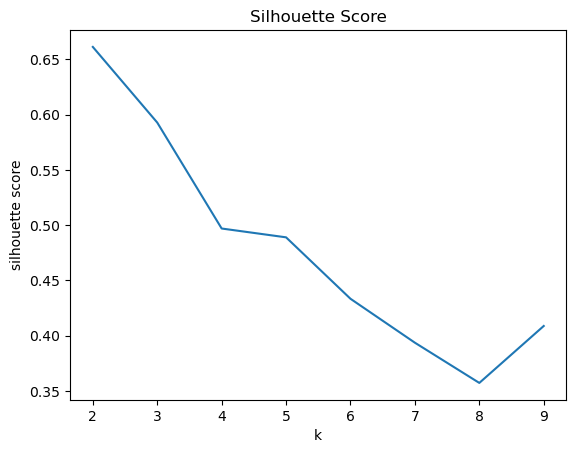

In [13]:
#Visualizing the silhouette scores in a plot 
import matplotlib.pyplot as plt 
  
plt.plot(range(2,10),silhouette_score) 
plt.xlabel('k') 
plt.ylabel('silhouette score') 
plt.title('Silhouette Score') 
plt.show()

In [14]:
#  Since there is no definitive answer as to what value of K is an acceptable value. I want to move forward with k = 3 Where a local maximum of Silhouette Score is detected.
# Trains a k-means model. 
kmeans = KMeans(featuresCol='scaledFeatures',k=3) 
model = kmeans.fit(final_data) 
predictions = model.transform(final_data)


In [15]:
# Printing cluster centers 
centers = model.clusterCenters() 
print("Cluster Centers: ") 
for center in centers: 
    print(center)

Cluster Centers: 
[ 6.35645488 12.40730852 37.41990178 13.93860446  9.7892399   2.41585309
 12.29286107]
[ 4.96198582 10.97871333 37.30930808 12.44647267  8.62880781  1.80062386
 10.41913733]
[ 4.07497225 10.14410142 35.89816849 11.80812742  7.54416916  3.15411286
 10.38031464]


In [17]:
# Showing the result of groupings:
predictions.select('prediction').show(100)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         0|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         2|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         0|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         2|
|         2|
|         2|
|         1|
|         2|
|         1|
|         1|
|         1|
|         1|
|         1|
|         2|
|         0|
|         0|
|         0|
|         0|

In [18]:
#End Session 
spark.stop() 